# Tidsserie av Burst Data

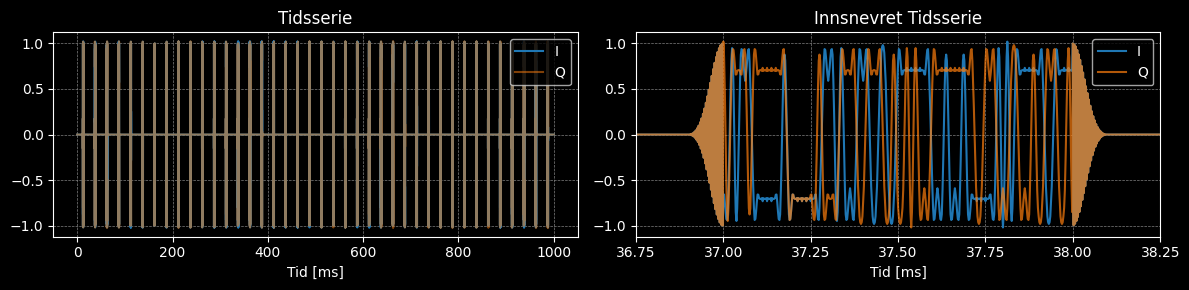

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Filnavn og lesing av data
filnavn = 'SimData/TxBurstData.bin'
burst_data = np.fromfile(filnavn, dtype=np.complex64)

# Definer samplingsfrekvens og tidsakse (ms)
samp_rate = 480e3
t = np.arange(len(burst_data)) / samp_rate * 1000  # Tidsakse, ms

# Filtrering for den innsnevrede tidsserien mellom 49 ms og 51 ms
start_time = 36.75  # Starttidspunkt for tidsvindu
end_time = 38.25    # Sluttidspunkt for tidsvindu
start_idx = np.searchsorted(t, start_time)  # Indeks for starttid
end_idx = np.searchsorted(t, end_time)      # Indeks for sluttid

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # Tre subplots, vertikal layout

# Plot hele tidsserien på første subplot (stor)
axs[0].plot(t, np.real(burst_data), label='I', color='tab:blue')
axs[0].plot(t, np.imag(burst_data), label='Q', color='tab:orange', alpha=0.5)
axs[0].set_title('Tidsserie')
axs[0].set_xlabel('Tid [ms]')
axs[0].legend(loc='upper right')
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)

# Plot innsnevret tidsserie for I (real del) på andre subplot
axs[1].plot(t[start_idx:end_idx], np.real(burst_data[start_idx:end_idx]), label='I', color='tab:blue')
axs[1].plot(t[start_idx:end_idx], np.imag(burst_data[start_idx:end_idx]), label='Q', color='tab:orange', alpha=0.7)
axs[1].set_title('Innsnevret Tidsserie')
axs[1].set_xlabel('Tid [ms]')
axs[1].legend(loc='upper right')
axs[1].set_xlim(start_time, end_time)  # Sett x-aksen til tidsvinduet
axs[1].set_xticks(np.arange(start_time, end_time+0.001, 0.25))  # Sett x-aksen til 0.5 ms intervaller
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)

# Juster layout for bedre visning
plt.savefig('Figurer/Tx_tid.pdf',format="pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


# Spektrum

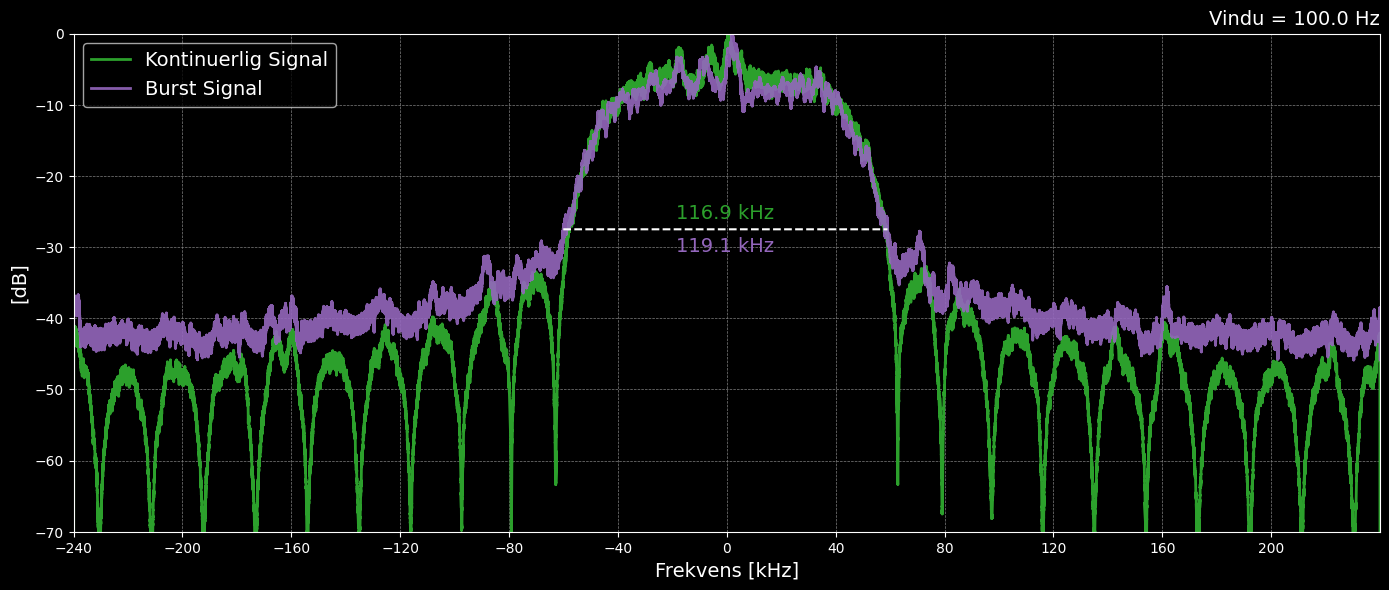

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

filnavn= 'SimData/TxKontData.bin'
kont_data = np.fromfile(filnavn, dtype=np.complex64)
samp_rate = 480e3
t = np.arange(len(kont_data)) / samp_rate * 1000  # Tidsakse, ms

# Spektrum for hele tidsserien
spektrum_kont = np.fft.fftshift(np.fft.fft(kont_data))
spektrum_kont_dB = 20 * np.log10(np.abs(spektrum_kont))
# Moving average for spektrumet

window_size = 100 # 100 samples vindu, 1 sample = 1 Hz, 100 samples = 100 Hz
spektrum_kont_dB = pd.Series(spektrum_kont_dB).rolling(window=window_size, center=True).mean().to_numpy()
spektrum_kont_dB = np.nan_to_num(spektrum_kont_dB, nan=np.nanmin(spektrum_kont_dB))  # Replace NaN with the minimum value
spektrum_kont_dB -= spektrum_kont_dB.max()  # Normaliser til dB

freqs = np.fft.fftshift(np.fft.fftfreq(len(kont_data), 1/samp_rate)) / 1e3  # Frekvensakse i kHz

#
spektrum_burst = np.fft.fftshift(np.fft.fft(burst_data))
spektrum_burst_dB = 20 * np.log10(np.abs(spektrum_burst))
spektrum_burst_dB = pd.Series(spektrum_burst_dB).rolling(window=window_size, center=True).mean().to_numpy()
spektrum_burst_dB = np.nan_to_num(spektrum_burst_dB, nan=np.nanmin(spektrum_burst_dB))  # Replace NaN with the minimum value
spektrum_burst_dB -= spektrum_burst_dB.max()  # Normaliser til dB
freqs_burst = np.fft.fftshift(np.fft.fftfreq(len(burst_data), 1/samp_rate)) / 1e3  # Frekvensakse i kHz

bw_threshold = -27.5
# find the bandiwdth 
mask_kont = np.where(spektrum_kont_dB > bw_threshold)[0]
mask_burst = np.where(spektrum_burst_dB > bw_threshold)[0]
bw_kont = freqs[mask_kont[-1]] - freqs[mask_kont[0]]
bw_burst = freqs_burst[mask_burst[-1]] - freqs_burst[mask_burst[0]]
freq_range_kont = freqs[mask_kont]
freq_range_burst = freqs_burst[mask_burst]

colors = ['tab:green', 'tab:purple']
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(freqs, spektrum_kont_dB, color=colors[0], label='Kontinuerlig Signal',linewidth=2)
plt.plot(freqs_burst, spektrum_burst_dB, color=colors[1], label='Burst Signal',linewidth=2, alpha=0.9)
plt.plot(freq_range_burst , [bw_threshold] * len(freq_range_burst), linestyle='--', color="white",zorder=2)
plt.annotate(f'{bw_kont:.1f} kHz', xy=((freq_range_burst[0]+freq_range_burst[-1])/2, bw_threshold+1), color=colors[0], fontsize=14, ha='center', va='bottom',zorder=3)
plt.annotate(f'{bw_burst:.1f} kHz', xy=((freq_range_burst[0]+freq_range_burst[-1])/2, bw_threshold-1), color=colors[1], fontsize=14, ha='center', va='top',zorder=3)
plt.annotate('Vindu = {:.1f} Hz'.format(window_size), xy=(1, 1.01), xycoords='axes fraction', fontsize=14, ha='right', va='bottom')
plt.xlabel('Frekvens [kHz]', fontsize=14)
plt.ylabel('[dB]', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(np.arange(-240, 241, 40))  # Sett x-aksen til 20 kHz intervaller
plt.xlim(min(freqs), max(freqs))
plt.yticks(np.arange(-70, 1, 10))  # Sett y-aksen til 20 dB intervaller
plt.ylim(-70, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Figurer/Tx_spektrum.pdf',format="pdf", bbox_inches='tight')
plt.show()


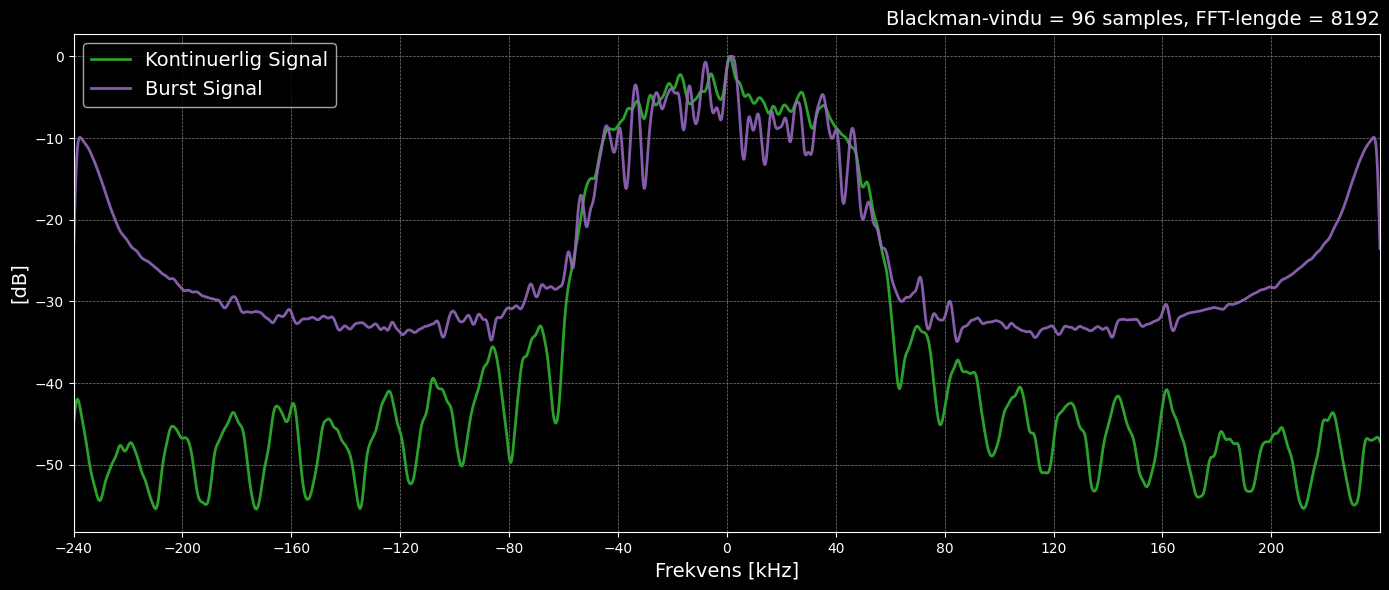

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# === PARAMETRE ===
filnavn = 'SimData/TxKontData.bin'
samp_rate = 480e3
fft_len = 8192                 # Endre for FFT-oppløsning
window_size = 96             # Glattingsvindu (antall samples)
window_func_name = 'blackman'     # Velg mellom: 'hann', 'blackman', 'hamming', 'bartlett', ...

# === VELG VINDUSFUNKSJON ===
window_functions = {
    'hann': np.hanning,
    'blackman': np.blackman,
    'hamming': np.hamming,
    'bartlett': np.bartlett
}

# Fallback hvis ukjent navn
window_func = window_functions.get(window_func_name.lower(), np.hanning)
filter_window = window_func(window_size)
filter_window /= filter_window.sum()

# === LAST INN DATA ===
kont_data = np.fromfile(filnavn, dtype=np.complex64)
t = np.arange(len(kont_data)) / samp_rate * 1000  # ms

# --- Funksjon for trygg log10-konvertering ---
def log_power_spectrum(spectrum):
    spectrum_magnitude = np.abs(spectrum)
    spectrum_magnitude[spectrum_magnitude == 0] = 1e-20  # Unngå log(0)
    return 20 * np.log10(spectrum_magnitude)

# --- FFT og spektrum ---
spektrum_kont = np.fft.fftshift(np.fft.fft(kont_data, n=fft_len))
spektrum_kont_dB = log_power_spectrum(spektrum_kont)
spektrum_kont_dB = np.convolve(spektrum_kont_dB, filter_window, mode='same')
spektrum_kont_dB -= spektrum_kont_dB.max()

# --- Burst-spektrum ---
spektrum_burst = np.fft.fftshift(np.fft.fft(burst_data, n=fft_len))
spektrum_burst_dB = log_power_spectrum(spektrum_burst)
spektrum_burst_dB = np.convolve(spektrum_burst_dB, filter_window, mode='same')
spektrum_burst_dB -= spektrum_burst_dB.max()

freqs = np.fft.fftshift(np.fft.fftfreq(fft_len, 1/samp_rate)) / 1e3


# === PLOTTING ===
colors = ['tab:green', 'tab:purple']
plt.figure(figsize=(14, 6))
plt.plot(freqs, spektrum_kont_dB, color=colors[0], label='Kontinuerlig Signal', linewidth=2)
plt.plot(freqs, spektrum_burst_dB, color=colors[1], label='Burst Signal', linewidth=2, alpha=0.9)

plt.annotate(f'{window_func_name.title()}-vindu = {window_size} samples, FFT-lengde = {fft_len}', 
             xy=(1, 1.01), xycoords='axes fraction', fontsize=14, ha='right', va='bottom')
plt.xlabel('Frekvens [kHz]', fontsize=14)
plt.ylabel('[dB]', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(np.arange(-240, 241, 40))
plt.xlim(min(freqs), max(freqs))
#plt.yticks(np.arange(-70, 1, 10))
#plt.ylim(-70, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Figurer/Tx_spektrum.pdf', format="pdf", bbox_inches='tight')
plt.show()

